In [6]:
import glob
import os
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.signal
import scipy.stats as st

# BE/Bi 103 utilities
import bebi103

# Image processing tools
import skimage
import skimage.io

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Justin's favorite settings
rc = {'lines.linewidth': 2,
      'axes.labelsize': 18,
      'axes.titlesize': 18,
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)


In [7]:
data_dir = './data/Cassiopea_Pulsation/day'

im_glob = os.path.join(data_dir, '*.TIF')

im_list = glob.glob(im_glob)

# Use skimage to read the image
im = skimage.io.imread(im_list[0])

# we just want to use one channel since it is all a repeat
# we create a function for this
def squish_rgb(fname):
    '''
    take in rgb image and just give us the first channel
    '''
    return skimage.io.imread(fname)[0,:,:]

In [8]:
# we want to create an roi
# if we pick one it will stay the same for all the frames
# we select vertices of the bottom frame second from the left
verts = [(496.91606404958685, 406.69266528925613),
 (499.2249483471075, 249.68853305785117),
 (345.68414256198355, 245.64798553719001),
 (341.64359504132238, 396.87990702479328)]

# use justin's roi utility
roi, roi_bbox, roi_box = bebi103.verts_to_roi(verts, 480, 640)

# define a function roi
def load_roi(fname, roi_bbox = None):
    '''
    define a roi area
    '''
    return squish_rgb(fname)[roi_bbox]


# we can load the stack of images
ic = skimage.io.ImageCollection(im_glob, conserve_memory = True, load_func = load_roi, roi_bbox = roi_bbox)

/Users/michellefry/anaconda/lib/python3.4/site-packages/skimage/external/tifffile/tifffile_local.py:3246: UserWarning: unexpected end of lzw stream (code 0)
  warnings.warn("unexpected end of lzw stream (code %i)" % code)


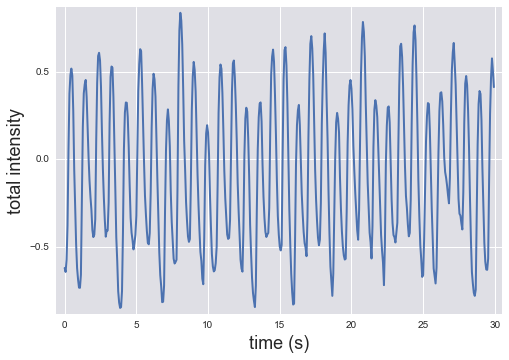

In [9]:
# we want to time stamp the data
# we were told the frame rate is 15 frames per second
t = np.arange(0, len(ic))/15

# I want to compute the intensity over time
# first we create a numpy array
intensity = np.empty(len(t))

# compute total intensity in the frame
for i, im in enumerate(ic):
    intensity[i] = ic[i][roi_box].sum()

# total intensity does not matter
# we can subtract the mean and normalize the difference to be between 1 and -1
intensity -= intensity.mean()
intensity = 1 + 2 / (intensity.max() - intensity.min()) * (intensity - intensity.max())

interval = np.s_[:450]
plt.plot(t[interval], intensity[interval])
plt.xlabel('time (s)')
plt.ylabel('total intensity')
plt.margins(0.02)


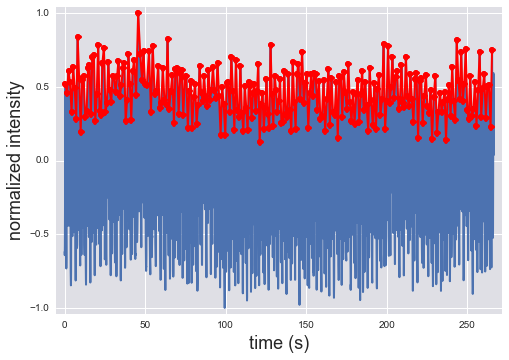

In [10]:
#define a minimum function
def maximum(x, y):
    '''
    find the maximum
    '''
    spike_min = np.argmax(y)
    y_vals = y[spike_min-1:spike_min+2]
    x_vals = x[spike_min-1:spike_min+2]
    a, b, c = np.polyfit(x_vals, y_vals, 2)
    x_max = -b / 2 / a
    return  x_max, a * x_max**2 + b * x_max + c

# to idenitfy the peaks we can do what we did for hw6pnt2
# first we define a threshold as zero since the maximum peaks is when it crosses zero
up = np.where(np.logical_and(intensity[:-1] < 0, intensity[1:] >= 0))[0]
down = np.where(np.logical_and(intensity[:-1] > 0, intensity[1:] <= 0))[0] + 1

# Make sure upcrossing are first
if down[0] < up[0]:
    down = down[1:]
    
# Make sure downcrossing last
if up[-1] > down[-1]:
    up = up[:-1]

# Find maxima
t_peaks = np.empty(len(up))
peaks = np.empty_like(t_peaks)
for i, uc in enumerate(up):
    ind = uc + np.argmax(intensity[uc:down[i]+1])
    t_peaks[i], peaks[i] = maximum(t[ind-1:ind+2], intensity[ind-1:ind+2])

plt.plot(t, intensity)
plt.xlabel('time (s)')
plt.ylabel('normalized intensity')
plt.margins(0.02)
plt.plot(t_peaks, peaks, color='red', marker='o')

